In [ ]:
!pip install --upgrade --force-reinstall box2d-py
!pip install --upgrade --force-reinstall gym[Box_2D]

     |████████████████████████████████| 450kB 5.2MB/s 
     |████████████████████████████████| 1.6MB 5.8MB/s 
     |████████████████████████████████| 27.4MB 108kB/s 
     |████████████████████████████████| 15.3MB 127kB/s 
     |████████████████████████████████| 1.0MB 37.5MB/s 
     |████████████████████████████████| 2.2MB 41.0MB/s 
     |████████████████████████████████| 829kB 22.6MB/s 
  Created wheel for gym: filename=gym-0.18.0-cp37-none-any.whl size=1656450 sha256=23464fcc1434e7f3c0aacb58646f15efa06c5277bac1c881f17b61d5db04bcb9
  Stored in directory: /root/.cache/pip/wheels/be/85/3b/480b828a4a697b37392740a040b8989f729d952b4e441a1877
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491058 sha256=cf970b6858d5e06c725dfb9ce3afe3ba525cff21032b894be66097d0862569cc
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
Successfully built gym future
ERROR: tensorflow 2.4.1 has requirement numpy~=1.19.2, but you'll

In [ ]:
from google.colab import files
import pandas as pd

In [ ]:
import gym
import tensorflow as tf
from tensorflow.keras import layers,activations
from tensorflow.keras.models import Model
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import random
from datetime import datetime
from google.colab import files
import pandas as pd


RANDOM_SEEDS = 123

now = datetime.now()
date_time = now.strftime("%Y%m%d_%H%M%S")

In [ ]:
# Ornstein-Uhlenbeck process
class OUNoise:
    def __init__(self, mu, sigma, theta=.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        x = (self.x_prev 
            + self.theta * (self.mu - self.x_prev) * self.dt 
            + self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape))
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x_initial if self.x_initial is not None else np.zeros_like(self.mu)

class SumTree(object):
    """
    This SumTree code is a modified version and the original code is from:
    https://github.com/jaara/AI-blog/blob/master/SumTree.py
    Story data with its priority in the tree.
    """
    data_pointer = 0

    def __init__(self, capacity):
        self.capacity = capacity  # for all priority values
        self.tree = np.zeros(2 * capacity - 1)
        # [--------------Parent nodes-------------][-------leaves to recode priority-------]
        #             size: capacity - 1                       size: capacity
        self.data = np.zeros(capacity, dtype=object)  # for all transitions
        # [--------------data frame-------------]
        #             size: capacity

    def add(self, p, data):
        tree_idx = self.data_pointer + self.capacity - 1
        self.data[self.data_pointer] = data  # update data_frame
        self.update(tree_idx, p)  # update tree_frame

        self.data_pointer += 1
        if self.data_pointer >= self.capacity:  # replace when exceed the capacity
            self.data_pointer = 0

    def update(self, tree_idx, p):
        change = p - self.tree[tree_idx]
        self.tree[tree_idx] = p
        # then propagate the change through tree
        while tree_idx != 0:    # this method is faster than the recursive loop in the reference code
            tree_idx = (tree_idx - 1) // 2
            self.tree[tree_idx] += change

    def get_leaf(self, v):
        """
        Tree structure and array storage:
        Tree index:
             0         -> storing priority sum
            / \
          1     2
         / \   / \
        3   4 5   6    -> storing priority for transitions
        Array type for storing:
        [0,1,2,3,4,5,6]
        """
        parent_idx = 0
        while True:     # the while loop is faster than the method in the reference code
            cl_idx = 2 * parent_idx + 1         # this leaf's left and right kids
            cr_idx = cl_idx + 1
            if cl_idx >= len(self.tree):        # reach bottom, end search
                leaf_idx = parent_idx
                break
            else:       # downward search, always search for a higher priority node
                if v <= self.tree[cl_idx]:
                    parent_idx = cl_idx
                else:
                    v -= self.tree[cl_idx]
                    parent_idx = cr_idx

        data_idx = leaf_idx - self.capacity + 1
        return leaf_idx, self.tree[leaf_idx], self.data[data_idx]

    @property
    def total_p(self):
        return self.tree[0]  # the root


class Memory(object):  # stored as ( s, a, r, s_ ) in SumTree
    """
    This Memory class is modified based on the original code from:
    https://github.com/jaara/AI-blog/blob/master/Seaquest-DDQN-PER.py
    """
    epsilon = 0.01  # small amount to avoid zero priority
    alpha = 0.7  # [0~1] convert the importance of TD error to priority
    beta = 0.5  # importance-sampling, from initial value increasing to 1
    beta_increment_per_sampling = 0.001
    abs_err_upper = 1.  # clipped abs error

    def __init__(self, capacity):
        self.tree = SumTree(capacity)
        self.sample_count = 0

    def __len__(self):
        return self.sample_count

    def store(self, transition):
        max_p = np.max(self.tree.tree[-self.tree.capacity:])
        if max_p == 0:
            max_p = self.abs_err_upper
        self.tree.add(max_p, transition)   # set the max p for new p
        self.sample_count = min(self.sample_count + 1, self.tree.capacity)

    def sample(self, n):
        b_idx, b_memory, ISWeights = np.empty((n,), dtype=np.int32), np.empty((n, self.tree.data[0].size)), np.empty((n, 1))
        pri_seg = self.tree.total_p / n       # priority segment
        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])  # max = 1

        a = self.tree.tree[-self.tree.capacity:]
        min_prob = np.min(a[a != 0]) / self.tree.total_p     # for later calculate ISweight
        for i in range(n):
            a, b = pri_seg * i, pri_seg * (i + 1)
            v = np.random.uniform(a, b)
            idx, p, data = self.tree.get_leaf(v)
            prob = p / self.tree.total_p
            ISWeights[i, 0] = np.power(prob/min_prob, -self.beta)
            b_idx[i], b_memory[i, :] = idx, data

        return b_idx, b_memory, ISWeights

    def batch_update(self, tree_idx, abs_errors):
        abs_errors += self.epsilon  # convert to abs and avoid 0
        clipped_errors = np.minimum(abs_errors, self.abs_err_upper)
        ps = np.power(clipped_errors, self.alpha)
        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)


def get_actor(state_shape, action_dim, upper_bound, units=(512,512)):
    last_init = tf.random_uniform_initializer(minval=-0.004, maxval=0.004)
    inputs = layers.Input(shape=(state_shape,))
    for idx, unit in enumerate(units):
        if idx == 0:
            out = layers.Dense(unit, name=f"lvl{idx+1}",activation="relu")(inputs)
        else:
            out = layers.Dense(unit, name=f"lvl{idx+1}",activation="relu")(out)
    outputs = layers.Dense(action_dim, name="Output", activation="tanh", kernel_initializer=last_init)(out)
    scaled_outputs = outputs * upper_bound
    model = Model(inputs,scaled_outputs)
    return model


def get_critic(state_shape, action_dim, state_units=(512,256),action_units=128,concat_units=128):
    state_input = layers.Input(shape=(state_shape), name="state_input")
    for idx, unit in enumerate(state_units):      
        if idx == 0:
            state_out = layers.Dense(unit, name=f"state_lvl{idx+1}", activation="relu")(state_input)
        else:
            state_out = layers.Dense(unit, name=f"state_lvl{idx+1}", activation="relu")(state_out)
    
    action_input = layers.Input(shape=(action_dim),name="action_input")
    action_out = layers.Dense(action_units, name="action_lvl", activation="relu")(action_input)
    
    concat = layers.Concatenate()([state_out,action_out])
    out = layers.Dense(concat_units, name="concat_lvl",activation="relu")(concat)
    outputs = layers.Dense(1)(out) # Q value

    model = Model([state_input, action_input], outputs)
    return model

@tf.function
def update_target(model, target_model, tau=0.001):
    weights = model.variables
    target_weights = target_model.variables
    for (a,b) in zip(target_weights,weights):
        a.assign(b * tau + a * (1 - tau))

In [ ]:
class DDPG:
    def __init__(self,
                 env,
                 per=False,
                 actor_lr=0.00005,
                 critic_lr=0.0005,
                 actor_units=(512,512),
                 state_units=(512,512),
                 action_units=128,
                 concat_units=256,
                 noise="OU",
                 tau=0.001,
                 gamma=0.99,
                 batch_size=256,
                 memory_size=2**20
    ):
        self.env = env
        self.per = per
        self.state_shape = env.observation_space.shape[0]
        self.action_dim = env.action_space.shape[0]
        self.upper_bound = env.action_space.high[0]
        self.lower_bound = env.action_space.low[0]
        if noise == "OU":
            self.noise = OUNoise(mu=np.zeros(self.action_dim),sigma=float(0.2)*np.ones(self.action_dim))
        else:
            self.noise = np.random.normal(scale=0.2, size=self.action_dim)
        self.actor_model = get_actor(self.state_shape, self.action_dim, self.upper_bound, actor_units)
        self.critic_model = get_critic(self.state_shape, self.action_dim, state_units, action_units, concat_units)
        self.target_actor_model = get_actor(self.state_shape, self.action_dim, self.upper_bound, actor_units)
        self.target_critic_model = get_critic(self.state_shape, self.action_dim, state_units, action_units, concat_units)
        self.target_actor_model.set_weights(self.actor_model.get_weights())
        self.target_critic_model.set_weights(self.critic_model.get_weights())
        self.actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
        self.critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
        self.gamma = gamma
        self.tau = tau
        self.batch_size = batch_size
        self.memory = Memory(capacity=memory_size) if per else deque(maxlen=memory_size)

    def policy(self, state, noise_object):
        sampled_actions = tf.squeeze(self.actor_model(state))

        noise = noise_object()
        sampled_actions = sampled_actions.numpy() + noise

        legal_action = np.clip(sampled_actions, self.lower_bound, self.upper_bound)
        return np.squeeze(legal_action)

    def record(self, obs_array):
        if self.per:
            transition = np.hstack(obs_array)
            self.memory.store(transition)
        else:
            self.memory.append(obs_array)    

    @tf.function(experimental_relax_shapes=True)
    def per_update(
        self, state_batch, action_batch, reward_batch, next_state_batch, done_batch, ISWeights
    ):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor_model(next_state_batch, training=True)
            y = reward_batch + self.gamma * self.target_critic_model(
                [next_state_batch, target_actions], training=True
            ) * (1. - done_batch)
            critic_value = self.critic_model([state_batch, action_batch], training=True)
            errors = y - critic_value
            critic_loss = tf.math.reduce_mean(ISWeights * tf.math.square(errors))

        critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
        self.critic_optimizer.apply_gradients(
            zip(critic_grad, self.critic_model.trainable_variables)
        )

        abs_errors = tf.reduce_sum(tf.abs(errors), axis=1)
        #self.memory.batch_update(tree_idx, abs_errors)

        with tf.GradientTape() as tape:
            actions = self.actor_model(state_batch, training=True)
            critic_value = self.critic_model([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        self.actor_optimizer.apply_gradients(
            zip(actor_grad, self.actor_model.trainable_variables)
        )
        return abs_errors

    @tf.function(experimental_relax_shapes=True)
    def update(
        self, state_batch, action_batch, reward_batch, next_state_batch, done_batch
    ):
        with tf.GradientTape() as tape:
            target_actions = self.target_actor_model(next_state_batch, training=True)
            y = reward_batch + self.gamma * self.target_critic_model(
                [next_state_batch, target_actions], training=True
            ) * (1. - done_batch)
            critic_value = self.critic_model([state_batch, action_batch], training=True)
            critic_loss = tf.keras.losses.Huber()(y,critic_value)

            critic_grad = tape.gradient(critic_loss, self.critic_model.trainable_variables)
            self.critic_optimizer.apply_gradients(
                zip(critic_grad, self.critic_model.trainable_variables)
            )

        with tf.GradientTape() as tape:
            actions = self.actor_model(state_batch, training=True)
            critic_value = self.critic_model([state_batch, actions], training=True)
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, self.actor_model.trainable_variables)
        self.actor_optimizer.apply_gradients(
            zip(actor_grad, self.actor_model.trainable_variables)
        )


    def replay(self):
        if self.per:
            tree_idx, samples, ISWeights = self.memory.sample(min(self.batch_size,len(self.memory)))
            ISWeights_batch = tf.convert_to_tensor(ISWeights,dtype=tf.float32)
            split_shape = np.cumsum([self.state_shape, self.action_dim, 1, self.state_shape])
            states, actions, rewards, next_states, dones = np.hsplit(samples, split_shape)
            state_batch = tf.convert_to_tensor(states)
            action_batch = tf.convert_to_tensor(actions)
            reward_batch = tf.convert_to_tensor(rewards, dtype=tf.float32)
            next_state_batch = tf.convert_to_tensor(next_states)
            done_batch = tf.convert_to_tensor(dones,dtype=tf.float32)
            abs_errors = self.per_update(state_batch, action_batch, reward_batch, next_state_batch, done_batch, ISWeights_batch)
            self.memory.batch_update(tree_idx, abs_errors.numpy())
        else:
            samples = random.sample(self.memory, min(self.batch_size,len(self.memory)))
            trans_s = np.array(samples,dtype=object).T
            state_batch = tf.convert_to_tensor(np.row_stack(trans_s[0]))
            action_batch = tf.convert_to_tensor(np.row_stack(trans_s[1]))
            reward_batch = tf.convert_to_tensor(np.row_stack(trans_s[2]),dtype=tf.float32)
            next_state_batch = tf.convert_to_tensor(np.row_stack(trans_s[3]))
            done_batch = tf.convert_to_tensor(np.row_stack(trans_s[4]),dtype=tf.float32)
            self.update(state_batch, action_batch, reward_batch, next_state_batch, done_batch)

    def train(self, max_episodes=2000, max_steps=1000):
        self.ep_reward_list = []
        self.avg_reward_list = []
        self.ep_steps_list = []

        for ep in range(max_episodes):
            prev_state = self.env.reset()
            episodic_reward = 0
            steps = 0
            
            while steps < max_steps:
                tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
                action = self.policy(tf_prev_state, self.noise)

                state, reward, done, _ = self.env.step(action)
                self.record([prev_state, action, reward, state, done])

                episodic_reward += reward
                self.replay()

                update_target(self.actor_model, self.target_actor_model, self.tau)
                update_target(self.critic_model, self.target_critic_model, self.tau)

                if done:
                    break

                prev_state = state
                steps += 1
            self.ep_reward_list.append(episodic_reward)
            # Mean of last 100 episodes
            avg_reward = np.mean(self.ep_reward_list[-100:])
            self.avg_reward_list.append(avg_reward)
            self.ep_steps_list.append(steps)
            avg_step = np.mean(self.ep_steps_list[-100:])
            if ep%10 == 0:
                print(f"Episode * {ep} * Avg Steps {avg_step} * Episodic Reward is ==> {episodic_reward} * Lastest 100 Episods Avg Reward is ==> {avg_reward}")


        plt.plot(self.avg_reward_list)
        plt.xlabel("Episode")
        plt.ylabel("Avg. Epsiodic Reward")
        plt.show()

        content = {"ep_reward":self.ep_reward_list,"avg_reward":self.avg_reward_list, "steps":self.ep_steps_list}
        df = pd.DataFrame(content)
        df.to_csv(f'ddpg_per_{self.per}_{date_time}.csv') 
        files.download(f'ddpg_per_{self.per}_{date_time}.csv')

In [ ]:
problem = 'LunarLanderContinuous-v2'
gym_env = gym.make(problem)
gym_env.seed(RANDOM_SEEDS)

[123]

In [ ]:
tf.keras.backend.clear_session()
ddpg = DDPG(gym_env,per=True)

Episode * 0 * Avg Steps 85.0 * Episodic Reward is ==> -38.98723359888106 * Lastest 100 Episods Avg Reward is ==> -38.98723359888106
Episode * 10 * Avg Steps 94.27272727272727 * Episodic Reward is ==> -573.8740710038464 * Lastest 100 Episods Avg Reward is ==> -752.2294821238579
Episode * 20 * Avg Steps 88.23809523809524 * Episodic Reward is ==> -610.8685863462115 * Lastest 100 Episods Avg Reward is ==> -781.7061040929841
Episode * 30 * Avg Steps 82.93548387096774 * Episodic Reward is ==> -851.6327485861467 * Lastest 100 Episods Avg Reward is ==> -745.8424666489403
Episode * 40 * Avg Steps 80.70731707317073 * Episodic Reward is ==> -1461.6018267607983 * Lastest 100 Episods Avg Reward is ==> -727.5453822324325
Episode * 50 * Avg Steps 76.41176470588235 * Episodic Reward is ==> -396.4509055994927 * Lastest 100 Episods Avg Reward is ==> -685.7241322629393
Episode * 60 * Avg Steps 78.06557377049181 * Episodic Reward is ==> -516.6639098961111 * Lastest 100 Episods Avg Reward is ==> -675.16662

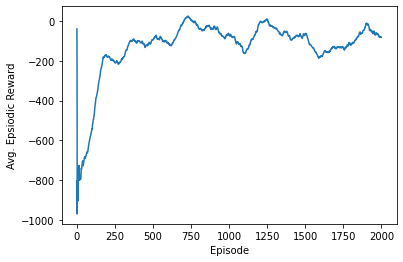

NameError: ignored

In [ ]:
ddpg.train(max_episodes=2000,max_steps=1000)